In [1]:
from  src.dataloader import *
from src.metrics import *
from src.resnet18 import *
from src.confusion_matrix import make_confusion_matrix
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms, datasets
import torch.nn as nn
import tensorflow as tf
from sklearn.metrics import fbeta_score, make_scorer, f1_score, accuracy_score, recall_score, precision_score, fbeta_score, precision_recall_curve, auc, roc_curve, log_loss, confusion_matrix
import torchvision.models as models
import os
from sklearn.manifold import TSNE
from tqdm import tqdm
import cv2
from PIL import Image

c:\Users\yanis\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] La procédure spécifiée est introuvable
  warn(f"Failed to load image Python extension: {e}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


716
torch.Size([32, 3, 224, 224])
tensor(0)


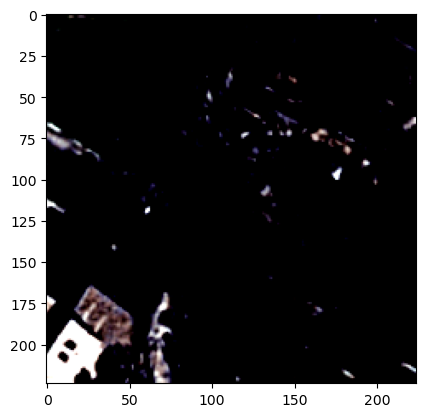

In [2]:
np.random.seed(123)
path_train="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset  = CustomImageDataset_path(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/", transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.RandomCrop(190), #On garde environ 75% de l'image
                                               transforms.ColorJitter(brightness=(0.5,1.5),contrast=0,saturation=0,hue=0),                                               transforms.RandomCrop(160),
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.3492203652858734, 0.3565990626811981, 0.3071053624153137],
                                                                    std= [0.2003859430551529, 0.18338431417942047, 0.17826561629772186]),

                                           ]))

transformed_test_dataset = CustomImageDataset_path(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.3498302698135376, 0.3575190603733063, 0.30798372626304626],
                                                                    std= [0.20142625272274017, 0.1843339055776596, 0.17957480251789093]),
                                           ]))

train_dataloader_augmente = DataLoader(transformed_train_dataset, batch_size=32, shuffle=True)
test_dataloader_augmente = DataLoader(transformed_test_dataset, batch_size=32, shuffle=True)

print(len(train_dataloader_augmente))
batch = next(iter(train_dataloader_augmente))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

In [3]:
resnet18 = models.resnet18(pretrained=True)
nr_filters = resnet18.fc.in_features  #number of input features of last layer
#On ne met pas de sigmoid dans la dernière couche. C'est composé par la loss BCEWithLogitsLoss qui applique une sigmoid afin de calculer la cross-enthropy
resnet18.fc = nn.Linear(nr_filters, 1)

resnet18.load_state_dict(torch.load("C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/trained_resnet18.pth"))
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
def embedding(data):
    resnet18.eval()
    out = resnet18.conv1(data) #pass through CNN
    out= resnet18.bn1(out)
    out=resnet18.relu(out)
    out=resnet18.maxpool(out)
    out=resnet18.layer1(out)
    out=resnet18.layer2(out)
    out=resnet18.layer3(out)
    out=resnet18.layer4(out)
    out=torch.flatten(out, 1)
    return out

In [5]:
features = None
labels = None
image_paths = None

for data in test_dataloader_augmente:
    inputs=data[0]
    targets=data[1]
    paths=data[2]
    
    output = embedding(inputs)
    current_features = output.detach().numpy()
    if features is not None:
        features = np.concatenate((features, current_features))
    else:
        features = current_features

    if labels is not None:
        labels = np.concatenate((labels, targets))
    else:
        labels = targets
    
    if image_paths is not None:
        image_paths = np.concatenate((image_paths, paths))
    else:
        image_paths = paths

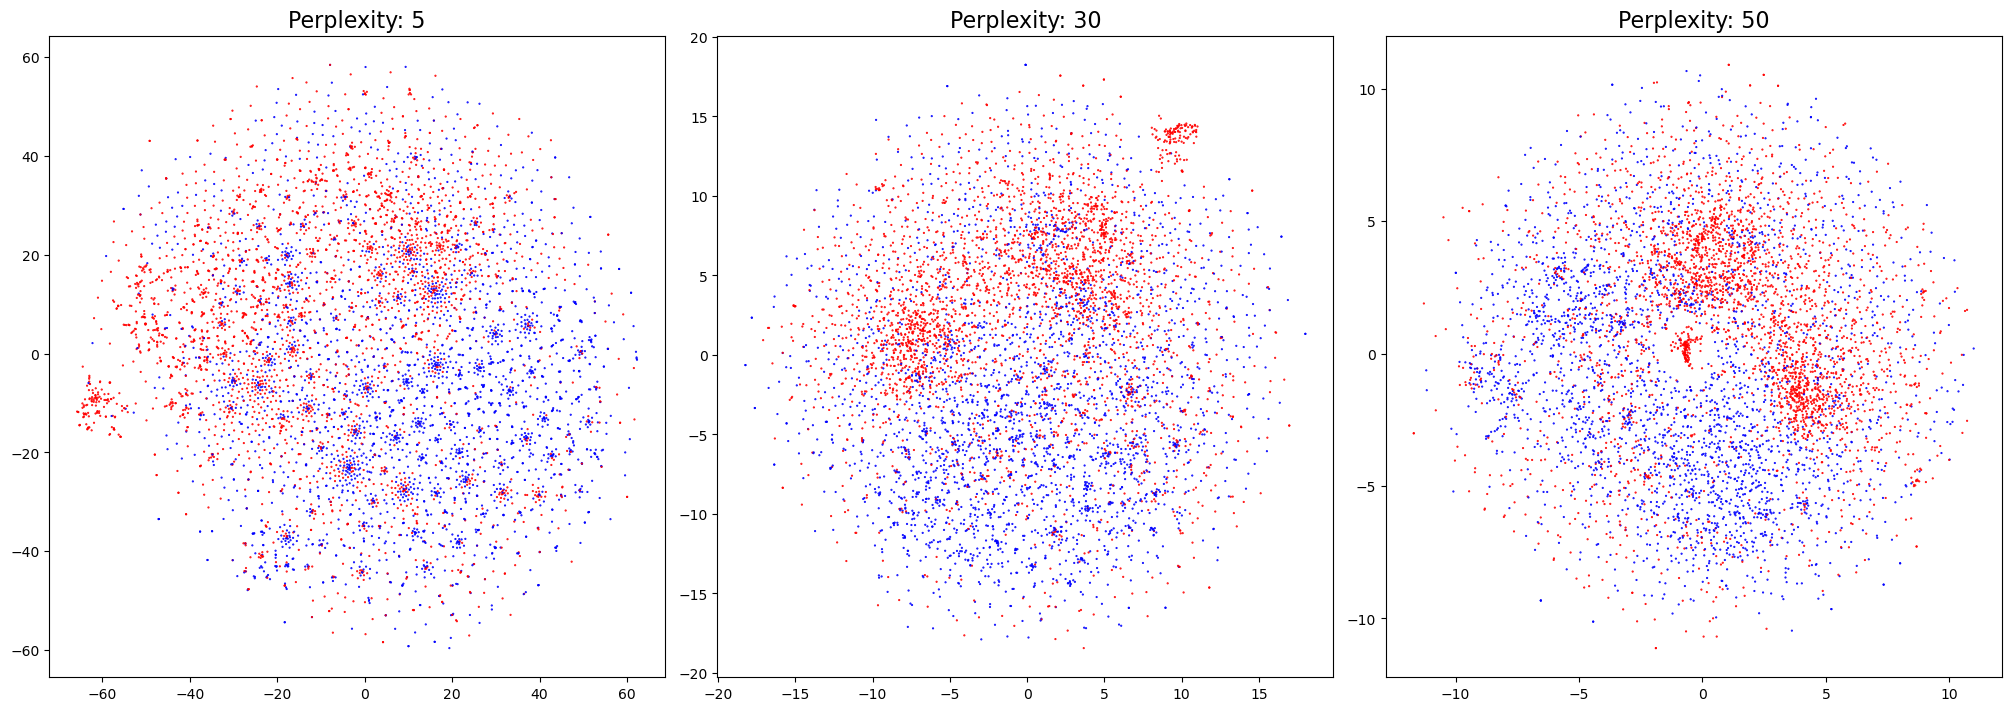

In [6]:
import itertools
fig, ax = plt.subplots(1, 3, figsize=(20,7), constrained_layout=True)

for c, per in zip(itertools.count(), [5, 30, 50]):
    tsne = TSNE(n_components=2,
                perplexity=per)
    tsne = tsne.fit_transform(features)
    scatter = ax[c].scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap=matplotlib.colors.ListedColormap(["red", "blue"]), s=0.3)
    ax[c].set_title(f'Perplexity: {per}', fontsize=16)  

In [7]:
tsne = TSNE(n_components=2, perplexity=30).fit_transform(features)

In [8]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

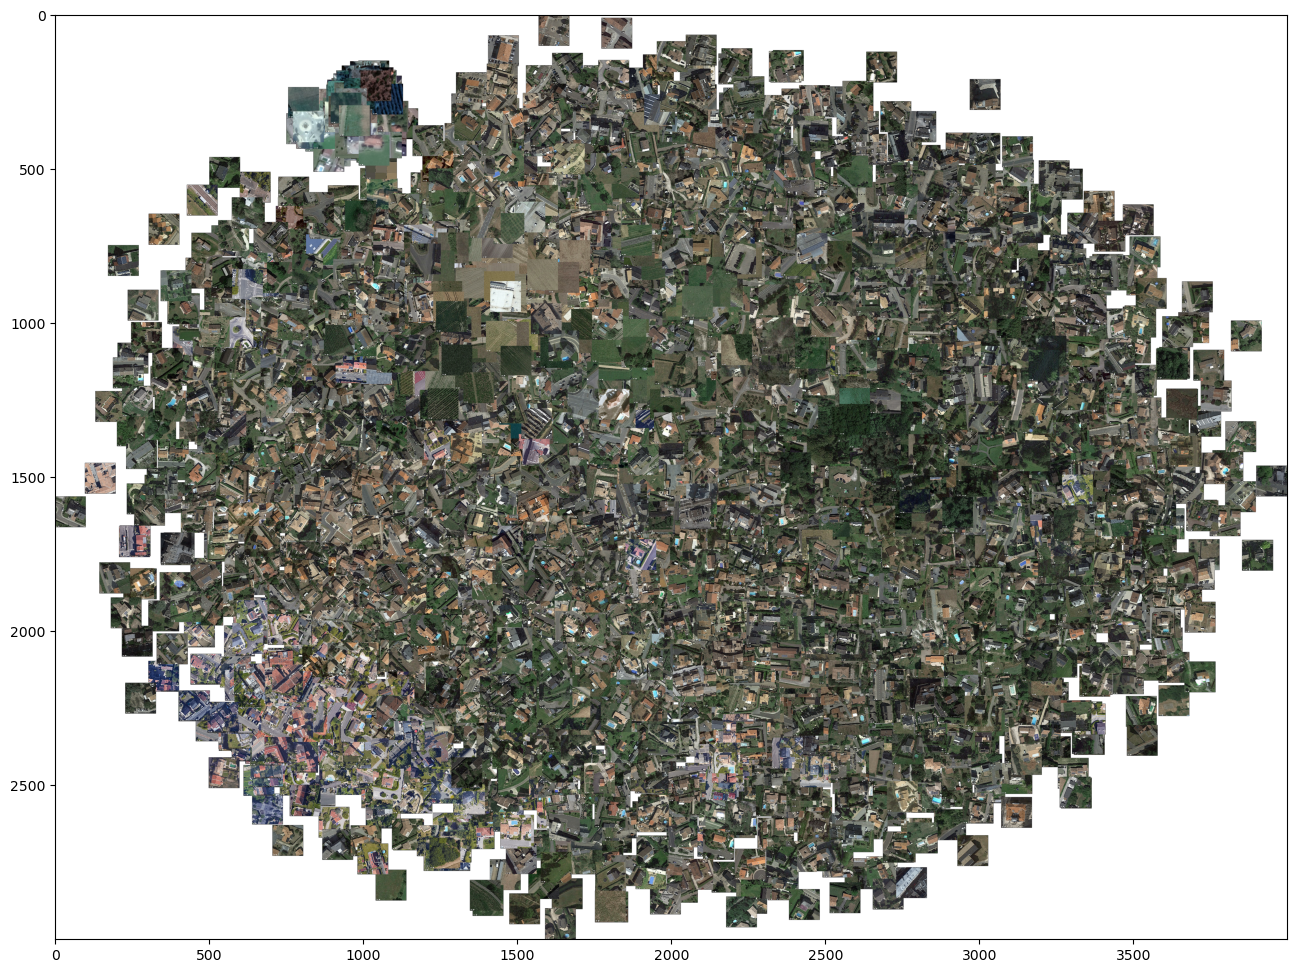

In [9]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(image_paths, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
plt.imshow(full_image)

In [10]:
colors_per_class = {
    0 : [0, 0, 255], #bleu
    1 : [255, 0, 0]  #rouge
}

In [11]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image


def draw_rectangle_by_class(image, label):
    image_height, image_width, _ = image.shape

    # get the color corresponding to image class
    color = colors_per_class[label]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color=color, thickness=5)

    return image


def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape

    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center, compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)

    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y


def visualize_tsne_images(tx, ty, images, labels, plot_size=1000, max_image_size=100):
    # we'll put the image centers in the central area of the plot
    # and use offsets to make sure the images fit the plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for image_path, label, x, y in tqdm(
            zip(images, labels, tx, ty),
            desc='Building the T-SNE plot',
            total=len(images)):  
        image = Image.open(image_path).convert('RGB')
        image = np.array(image) 
        image = image[:, :, ::-1].copy() 


        # scale the image to put it to the plot
        image = scale_image(image, max_image_size)

        # draw a rectangle with a color corresponding to the image class
        image = draw_rectangle_by_class(image, label)

        # compute the coordinates of the image on the scaled plot visualization
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

        # put the image to its TSNE coordinates using numpy subarray indices
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

    plt.imshow(tsne_plot[:, :, ::-1])
    plt.show()

def visualize_tsne_points(tx, ty, labels):
    # initialize matplotlib plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # for every class, we'll add a scatter plot separately
    for label in colors_per_class:
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(labels) if l == label]

        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)

        # convert the class color to matplotlib format:
        # BGR -> RGB, divide by 255, convert to np.array
        color = np.array([colors_per_class[label][::-1]], dtype=np.float) / 255

        # add a scatter plot with the correponding color and label
        ax.scatter(current_tx, current_ty, c=color, label=label)

    # build a legend using the labels we set previously
    ax.legend(loc='best')

    # finally, show the plot
    plt.show()


def visualize_tsne(tsne, images, labels, plot_size=1000, max_image_size=100):
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    # scale and move the coordinates so they fit [0; 1] range
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    # visualize the plot: samples as colored points
    visualize_tsne_points(tx, ty, labels)

    # visualize the plot: samples as images
    visualize_tsne_images(tx, ty, images, labels, plot_size=plot_size, max_image_size=max_image_size)

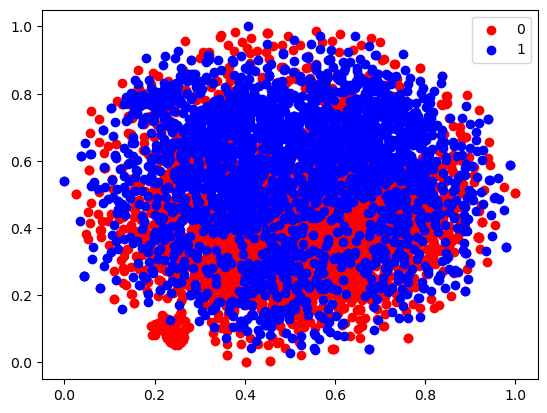

Building the T-SNE plot: 100%|██████████| 5727/5727 [00:15<00:00, 375.52it/s]


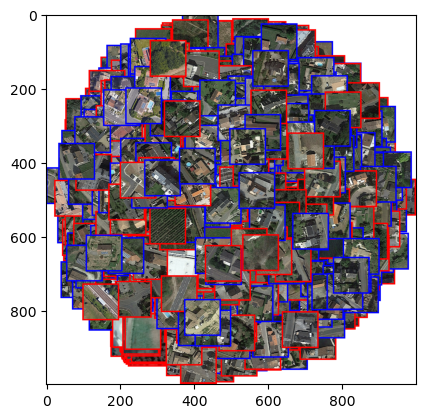

In [12]:
visualize_tsne(tsne, image_paths, labels)